In [2]:
import os, math, cv2, sys, glob, random, argparse
from multiprocessing import Pool
from itertools import product
import numpy as np
import rasterio

%matplotlib inline
import matplotlib.pyplot as plt


sys.path.append('../utils')
sys.path.append('../models')
from dataloaders import *
from unet_blocks import *

In [3]:
def read_band(band):
    return rasterio.open(band).read()[0]

def read_bands(band_paths):
    pool = Pool(26)
    bands = pool.map(read_band, band_paths)
    pool.close()
    return bands

def _match_band(two_date):
    return match_band(two_date[1], two_date[0])

def match_bands(date1, date2):
    pool = Pool(13)
    date2 = pool.map(_match_band, [[date1[i], date2[i]] for i in range(len(date1))])
    pool.close()
    return date2

def _resize(band):
    return cv2.resize(band, (10980, 10980))

def stack_bands(bands):
    pool = Pool(13)
    bands = pool.map(stretch_8bit, bands)
    pool.close()

    return cv2.merge(bands).astype(np.uint8)

In [4]:
data_path = '../../../Yiwu/cd_out/'
tiles = os.listdir(data_path)

In [43]:
# aa = rasterio.open(data_path + 'T51RTM_20151126T024032_20151126T024032.tif').read()[0]
# bb = rasterio.open(data_path + 'T51RTM_20170228T023631_20170228T023631.tif').read()[0]
# cc = rasterio.open(data_path + 'T51RTM_20171225T024121_20171225T024121.tif').read()[0]
ab = rasterio.open(data_path + 'T19TCG_20160823T153602_20181111T153551.tif').read()[0]
# ba = rasterio.open(data_path + 'T51RTM_20170228T023631_20151126T024032.tif').read()[0]
# bc = rasterio.open(data_path + 'T51RTM_20170228T023631_20171225T024121.tif').read()[0]
# cb = rasterio.open(data_path + 'T51RTM_20171225T024121_20170228T023631.tif').read()[0]
# ac = rasterio.open(data_path + 'T51RTM_20151126T024032_20171225T024121.tif').read()[0]
# ca = rasterio.open(data_path + 'T51RTM_20171225T024121_20151126T024032.tif').read()[0]

In [20]:
a = cv2.imread('../../../Yiwu/emp_ana/T19TCG_20160823T153602.png')
b = cv2.imread('../../../Yiwu/emp_ana/T19TCG_20181111T153551.png')
# c = cv2.imread('../../../Yiwu/emp_ana/T51RTM_20171225T024121.png')
# c = cv2.imread('../../../Yiwu/emp_ana/T51RTM_20181001T023551.png')

In [6]:
# a_c_sum = a_b + b_c  
# a_c_sum[a_c_sum > 0] = 1

# a_c_and = np.logical_and(a_c_sum,a_c)

# ab_or_bc = np.logical_or(a_b,b_c)
# ac_and_ab_or_bc = np.logical_and(ab_or_bc, a_c)

In [38]:
# #property a<->a
# f = plt.figure(figsize=(15,10))

# f.add_subplot(1,3,1)
# plt.imshow(aa)
# plt.axis('off')
# plt.title('201511-201511')


# f.add_subplot(1,3,2)
# plt.imshow(bb)
# plt.axis('off')
# plt.title('201702-201702')


# f.add_subplot(1,3,3)
# plt.imshow(aa)
# plt.axis('off')
# plt.title('201712-201712')

In [40]:
sx, ex = 7000, 7500
sy, ey = 7000, 7300

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


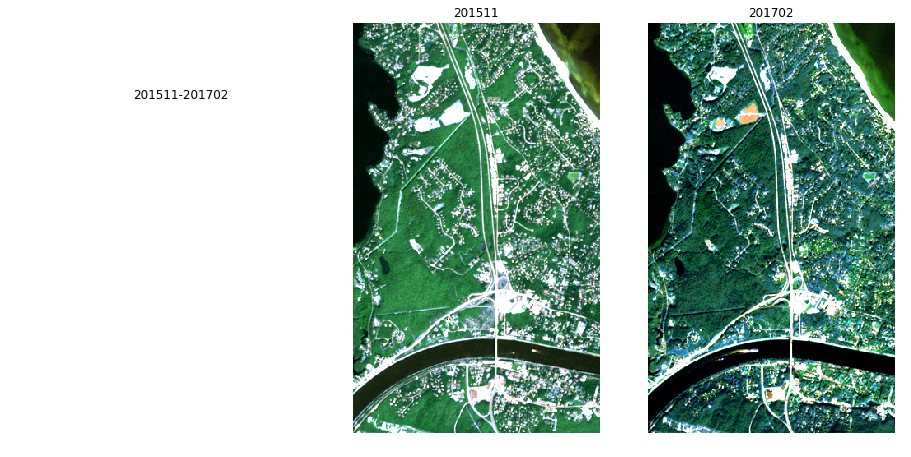

In [41]:
#property a->b, b->a
f = plt.figure(figsize=(15,10))

f.add_subplot(1,3,1)
plt.imshow(ab[sx:ex,sy:ey])
plt.axis('off')
plt.title('201511-201702')


# f.add_subplot(3,3,2)
# plt.imshow(ba[sx:ex,sy:ey])
# plt.axis('off')
# plt.title('201702-201511')


f.add_subplot(1,3,2)
plt.imshow(a[sx:ex,sy:ey])
plt.axis('off')
plt.title('201511')

# f.add_subplot(3,3,4)
# plt.imshow(bc[sx:ex,sy:ey])
# plt.axis('off')
# plt.title('201702-201712')


# f.add_subplot(3,3,5)
# plt.imshow(cb[sx:ex,sy:ey])
# plt.axis('off')
# plt.title('201712-201702')


f.add_subplot(1,3,3)
plt.imshow(b[sx:ex,sy:ey])
plt.axis('off')
plt.title('201702')

# f.add_subplot(3,3,7)
# plt.imshow(ac[sx:ex,sy:ey])
# plt.axis('off')
# plt.title('201511-201712')


# f.add_subplot(3,3,8)
# plt.imshow(ca[sx:ex,sy:ey])
# plt.axis('off')
# plt.title('201712-201511')


# f.add_subplot(3,3,9)
# plt.imshow(c[sx:ex,sy:ey])
# plt.axis('off')
# plt.title('201712')
plt.show()

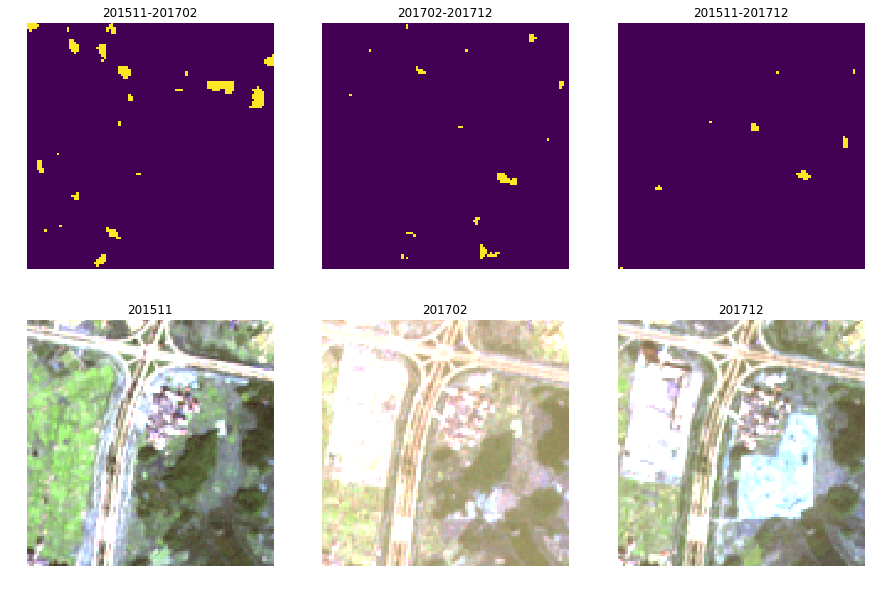

In [10]:
#property a->b U b->c == a->c
f = plt.figure(figsize=(15,10))


f.add_subplot(2,3,1)
plt.imshow(ab[sx:ex,sy:ey])
plt.axis('off')
plt.title('201511-201702')

f.add_subplot(2,3,2)
plt.imshow(bc[sx:ex,sy:ey])
plt.axis('off')
plt.title('201702-201712')

f.add_subplot(2,3,3)
plt.imshow(ac[sx:ex,sy:ey])
plt.axis('off')
plt.title('201511-201712')


f.add_subplot(2,3,4)
plt.imshow(a[sx:ex,sy:ey])
plt.axis('off')
plt.title('201511')

f.add_subplot(2,3,5)
plt.imshow(b[sx:ex,sy:ey])
plt.axis('off')
plt.title('201702')

f.add_subplot(2,3,6)
plt.imshow(c[sx:ex,sy:ey])
plt.axis('off')
plt.title('201712')

plt.show()

In [29]:
# for w in [1,2,3]:#[4,6,8,10,12,14,16,18,20]:
#     change_in_both = 0
#     change_in_either = 0
#     for i in range(0,10980,w):
#         for j in range(0,10980,w):
#             if np.sum(ab_or_bc[i:i+w,j:j+w]) > 0 and np.sum(a_c[i:i+w,j:j+w]) > 0:
#                 change_in_both += 1
#             if np.sum(ab_or_bc[i:i+w,j:j+w]) == 0 and np.sum(a_c[i:i+w,j:j+w]) > 0:
#                 change_in_either += 1
#             if np.sum(ab_or_bc[i:i+w,j:j+w]) > 0 and np.sum(a_c[i:i+w,j:j+w]) == 0:
#                 change_in_either += 1

#     print (w, change_in_both / change_in_either)

In [2]:
#w    percentage matches
#1 0.1091
#2 0.1171
#3 0.1290
#4, 0.135
#6, 0.159
#8, 0.172
#10, 0.204
#12, 0.226
#14, 0.256
#16, 0.262
#18, 0.313
#20, 0.345

In [11]:
d1_path = glob.glob('../../../Yiwu/SAFES/*20171221T153639*T19TCG*/GRANULE/**/IMG_DATA/*_B*.jp2')[0][:-7]
# d2_path = glob.glob('../../../Yiwu/SAFES/*20181111T153551*T19TCG*/GRANULE/**/IMG_DATA/*_B*.jp2')[0][:-7]
# d3_path = glob.glob('../../../Yiwu/SAFES/*20171225T024121*T51RTM*/GRANULE/**/IMG_DATA/*_B*.jp2')[0][:-7]
# d4_path = glob.glob('../../../Yiwu/SAFES/*20181001T023551*T51RTM*/GRANULE/**/IMG_DATA/*_B*.jp2')[0][:-7]

In [12]:
d1_bands = [d1_path + 'B02.jp2', d1_path + 'B03.jp2', d1_path + 'B04.jp2']
# d2_bands = [d2_path + 'B02.jp2', d2_path + 'B03.jp2', d2_path + 'B04.jp2']
# d3_bands = [d3_path + 'B02.jp2', d3_path + 'B03.jp2', d3_path + 'B04.jp2']
# d4_bands = [d4_path + 'B02.jp2', d4_path + 'B03.jp2', d4_path + 'B04.jp2']


In [ ]:
# #load bands for two dates and do preprocessing
# d1d2 = read_bands(d1_bands + d2_bands)
# d1d2[13:] = match_bands(d1d2[:13], d1d2[13:])
# d1, d2 = stack_bands(d1d2)

In [13]:
d1d2 = read_bands(d1_bands)

In [14]:
# d1d2[3:6] = match_bands(d1d2[:3], d1d2[3:6])
# d1d2d3d4[6:9] = match_bands(d1d2d3d4[:3], d1d2d3d4[6:9])
# d1d2d3d4[9:] = match_bands(d1d2d3d4[:3], d1d2d3d4[9:])

In [15]:
d1 = d1d2[:3]
# d2 = d1d2[3:6]
# d3 = d1d2d3d4[6:9]
# d4 = d1d2d3d4[9:]
del d1d2

In [16]:
d1 = stack_bands(d1)

In [10]:
d2 = stack_bands(d2)
# d3 = stack_bands(d3)
# d4 = stack_bands(d4)

In [17]:
cv2.imwrite('../../../Yiwu/emp_ana/T19TCG_20171221T153639.png',d1.astype(np.uint8))
# cv2.imwrite('../../../Yiwu/emp_ana/T19TCG_20181111T153551.png',d2.astype(np.uint8))
# cv2.imwrite('../../../Yiwu/emp_ana/T51RTM_20171225T024121.png',d3.astype(np.uint8))
# cv2.imwrite('../../../Yiwu/emp_ana/T51RTM_20181001T023551.png',d4.astype(np.uint8))

True

In [9]:
tifs = os.listdir('../../../Yiwu/cd_out/')

for tif in tifs:
    r = rasterio.open('../../../Yiwu/cd_out/' + tif, 'r')
    data = r.read()
    data = data * 255
    r.update(data)
    r.close()

AttributeError: 'DatasetReader' object has no attribute 'update'